# Description

To detect the emotional arcs of a story, we implement the following steps:
1. Use some sentiment scoring alorithm to detect the line-by-line sentiment of each document.
2. Normalize the entire document list to a standard length, resample aggregated sentiment scores into even intervals.
    1. Compute a moving average of the sentiment scores and aggregate to a minute by minute level.
3. Compute the correlational matrix of all documents.
    1. Construct a network graph of the correlational matrix.
    2. Partition the graph using some graph partiioning algorithm.
4. Compute the average sentiment in the normalized time domain by partition to visualize partion level trends.

# 1. Line by Line sentiment scoring

We use sentinetwordnet (Baccianella et al 2010). This is implemented in the standard NLP library `textblob`.


In [1]:
# Required non-standard libaries
# ! pip install textblob
# ! pip install networkx
# ! pip install python-louvain
# Imports / Required 
import numpy as np, pandas as pd, datetime, networkx as nx, os, matplotlib.pyplot as plt, datetime, progressbar, community
from textblob import TextBlob
from itertools import chain
%matplotlib inline


In [2]:
# Read in some sample files
df = pd.read_csv('../Data/scripts.csv', index_col  = 0)
df.start_t = pd.to_datetime(df.start_t) # this takes a bit of time, ironically
df.end_t = pd.to_datetime(df.end_t)

In [3]:
print('This sample dataset has a list of  {} cleaned scripts from subtitles'.format(len(df.ttid.unique())))

This sample dataset has a list of  187 cleaned scripts from subtitles


In [4]:
df.head() # id, start, end, txt, title, genre

,ttid,start_t,end_t,txt,movie_title,genre
0,tt0121766,2019-12-20 00:03:07,2019-12-20 00:03:08,"Lock onto him, R2.",Star Wars: Episode III - Revenge of the Sith,adventure
1,tt0121766,2019-12-20 00:03:09,2019-12-20 00:03:12,"Master, General Grievous's ship is directly ah...",Star Wars: Episode III - Revenge of the Sith,adventure
2,tt0121766,2019-12-20 00:03:12,2019-12-20 00:03:14,the one crawling with vulture droids.,Star Wars: Episode III - Revenge of the Sith,adventure
3,tt0121766,2019-12-20 00:03:14,2019-12-20 00:03:17,"I see it. Oh, this is going to be easy.",Star Wars: Episode III - Revenge of the Sith,adventure
4,tt0121766,2019-12-20 00:03:25,2019-12-20 00:03:27,"- Oddball, do you copy? - Copy, Red Leader.",Star Wars: Episode III - Revenge of the Sith,adventure


In [5]:
# apply polarity scoring, this step takes a minute
df['pol'] = df.txt.apply(lambda x: TextBlob(x).sentiment.polarity)

Text(0, 0.5, 'Count of Lines')

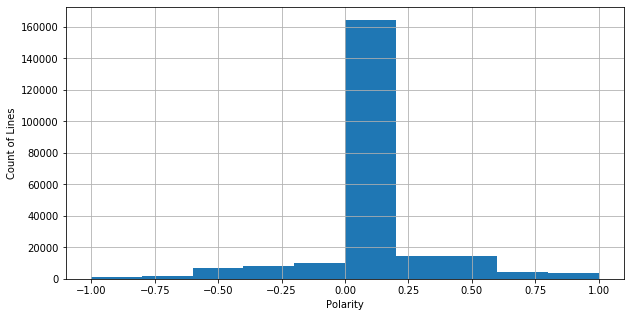

In [6]:
df.pol.hist(figsize = (10,5)) # distribution of polarity
plt.xlabel('Polarity')
plt.ylabel('Count of Lines')

Text(0, 0.5, 'Count of Lines')

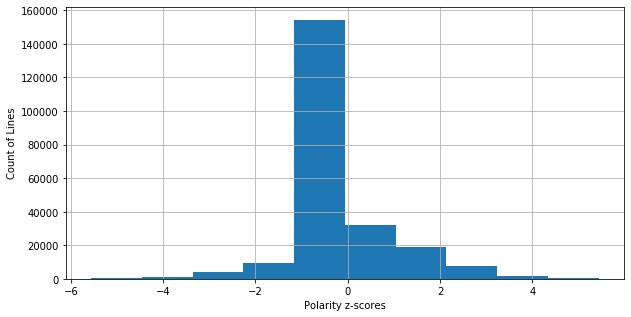

In [7]:
# We want to normalize the polarity score to make it comparable between movies
# It isn't the absolute polarity that matters, but the degree to which sentiment detatches from the norm of each movie
df['normed_pol'] = (df.pol-df.groupby('ttid')['pol'].transform(np.mean))/df.groupby('ttid')['pol'].transform(np.std)  
df.normed_pol.hist(figsize = (10,5)) # The distribution looks a little different now
plt.xlabel('Polarity z-scores')
plt.ylabel('Count of Lines')

# 2. Resampling to normalize time

In [8]:
# Deal w/ time variables
df['t'] = (df.end_t-df.start_t)/2+df.start_t
df.sort_values(by = ['ttid','t'], inplace = True)
df.t = pd.to_datetime(df.t)
df['time_left'] = ((df.groupby('ttid')['t'].transform(np.max)-df.t)/np.timedelta64(1, 'm'))
df['runtime']=(df.groupby('ttid')['t'].transform(np.max)-df.groupby('ttid')['t'].transform(np.min))/np.timedelta64(1,'m')
df['run_percent'] = (df.runtime-df.time_left)/df.runtime
# make normed t
total_mins_norm = 100
start = pd.to_datetime(datetime.date.today())
df['normed_t'] = df.run_percent.apply(lambda x: start + datetime.timedelta(seconds=x*total_mins_norm*60))
df['normed_t'] = pd.to_datetime(df.normed_t)

C:\Users\yangy\Anaconda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  import sys


Text(0.5, 0, 'Normed "t"')

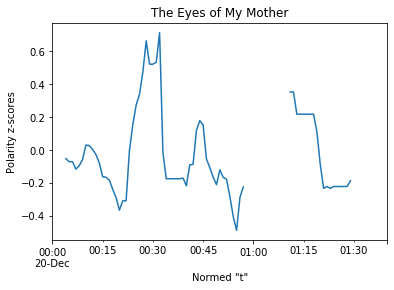

In [9]:
# Example sample of one random movie's polarity timeline
ttid = np.random.choice(df.ttid.unique())
tit = list(df.loc[df.ttid ==ttid, 'movie_title'])[0]
temp = df[df.ttid == ttid]
temp = temp.resample('1T', on = 'normed_t')['normed_pol'].agg([np.nanmean, 'std']) # Aggregate to % level
# temp.index = temp.index
temp.rolling(10, min_periods=3).apply(np.nanmean)['nanmean'].plot(title = tit) # Plot smoothed rolling avg polarity
plt.ylabel('Polarity z-scores')
plt.xlabel('Normed "t"')

In [10]:
# Resample entire dataframe
resample_level = '1t'
try:
    df.set_index('normed_t', inplace = True)
except:
    pass
df_resample = df.groupby([df.ttid, pd.Grouper(freq=resample_level, level='normed_t')])['normed_pol'].mean().reset_index()

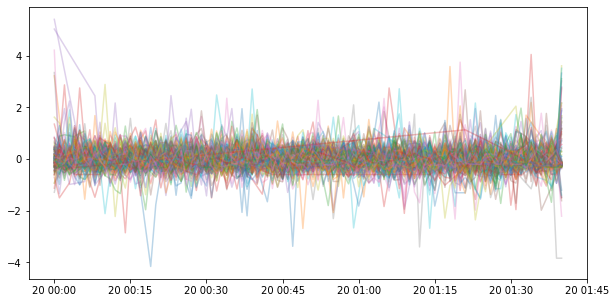

In [11]:
# Plot all data, looks like noise!
plt.figure(figsize = (10,5))
temp = df_resample.groupby(['normed_t', 'ttid'])['normed_pol'].mean().reset_index()
for ttid  in temp.ttid.unique():
    plt.plot(temp.loc[temp.ttid==ttid,'normed_t'],temp.loc[temp.ttid==ttid,'normed_pol'], alpha = .3)

C:\Users\yangy\Anaconda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  This is separate from the ipykernel package so we can avoid doing imports until


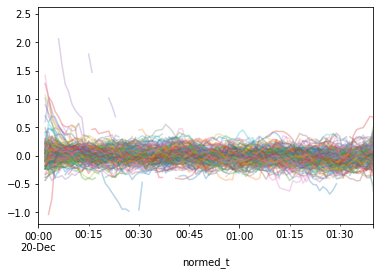

In [12]:
# Plot again with a bit of smoothing
df_smooth = df_resample.set_index('normed_t')
df_smooth = df_smooth.groupby('ttid')['normed_pol'].rolling(window = 10, min_periods = 3).apply(np.nanmean).reset_index()
df_smooth.groupby(['normed_t','ttid'])['normed_pol'].mean().unstack('ttid').plot(legend = False, alpha = .3)

# 3. Construct Graph

In [13]:
# Correlation Matrix
corrs = df_smooth.groupby(['normed_t','ttid'])['normed_pol'].mean().unstack('ttid').corr()
# Get rid of negative correlations
normed_corr_matrix = np.maximum(np.array(corrs),np.zeros(corrs.shape))
# Correlations are symmetric, need only off diagonal lower triangular matrix
normed_corr_matrix = np.tril(normed_corr_matrix,-1)

# Construct Graph, G, using networkx constructor from_numpy_matrix
G = nx.from_numpy_matrix(normed_corr_matrix)
# Save dictionary of node labels
node_labels = dict( zip( range(len(corrs)),corrs.columns.values))

# Remove Empty Edges
edgelist = [e[:2] for e in G.edges(data=True) if (e[-1]['weight']==0)|pd.isnull(e[-1]['weight'])]
for e in edgelist:
    G.remove_edge(*e)
# Cluster / Partition movies using the "Louvain algorithm, implemented in python-louvain package" 
res = 1 # Choose a partition level, results highly sensitive to this parameter
partition = community.best_partition(G, resolution=res)

# Data frame of partitions
parts = pd.DataFrame(partition.items())
parts.columns = ['id', 'part']
parts['ttid'] = parts.id.map(node_labels) # get back partition IDs

parts.head() # looks like this

,id,part,ttid
0,0,0,tt0121766
1,1,1,tt0293564
2,2,2,tt0299172
3,3,0,tt0337978
4,4,1,tt0350261


# 4. Visualize Partitions

In [14]:
df_smooth = df_smooth.merge(parts[['ttid', 'part']], on = 'ttid', how = 'left')

Number of edges included: 3113


C:\Users\yangy\Anaconda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Legend does not support None instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists


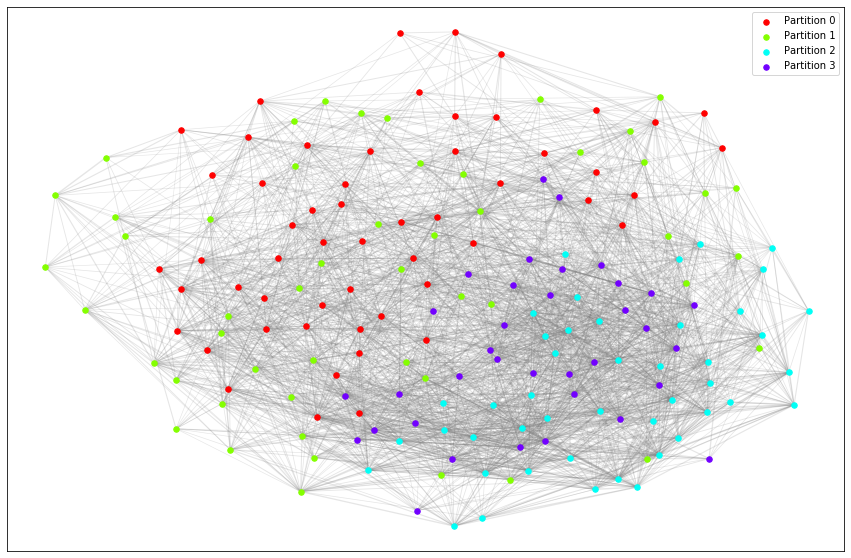

In [15]:
# Visualize the graph constructed
np.random.seed(100) # ensures same initialization, results in same positions each time rather than a rotation thereof
pos=nx.fruchterman_reingold_layout(G, weight = 'weight') # Create position of nodes using fruchterman reingold algorithm
cmin = .3 # minimum correlation to include
edges = [e[:2] for e in G.edges(data=True) if e[-1]['weight']>cmin] # Get edges w/ correlation > cmin
edgewiths = np.array([e[-1].get('weight') for e in G.edges(data = True) if e[-1].get('weight')>cmin])
nodes = list(set(chain(*edges)))
print('Number of edges included: {}'.format(len(edges)))
# Draw Graph
# Draw all edges
cmap = plt.get_cmap('hsv') # Colormap
plt.figure(figsize = (15,10))
nx.draw_networkx_edges(G, pos,edgelist = edges, alpha = .2, width = edgewiths*2,arrows=False,edge_color = 'gray')
# color nodes by partition
pts = list()
for pt in sorted(parts.part.unique()):
    nodelist = list(parts.loc[(parts.part==pt)&(parts.id.isin(nodes)), 'id'])    
    color = cmap(pt/parts.part.max())
    color = np.array(color).reshape(1,len(color)) # Reshape
    pt = nx.draw_networkx_nodes(G, pos, nodelist = nodelist, node_size = 30, node_color  = color)
    pts.append(pt)

# Turn off tick labels, set axes limits
positions = np.array([pos[p] for p in nodes])
xmin,xmax = np.min(positions[:,0]),np.max(positions[:,0])
xpad = (xmax-xmin)*.05
ymin,ymax = np.min(positions[:,1]),np.max(positions[:,1])
ypad = (ymax-ymin)*.05

plt.ylim([ymin-ypad,ymax+ypad])
plt.xlim([xmin-xpad,xmax+ypad])
plt.yticks([])
plt.xticks([])
plt.legend(pts, ['Partition {}'.format(p) for p in range(len(pts))])

C:\Users\yangy\Anaconda\envs\tf_gpu\lib\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


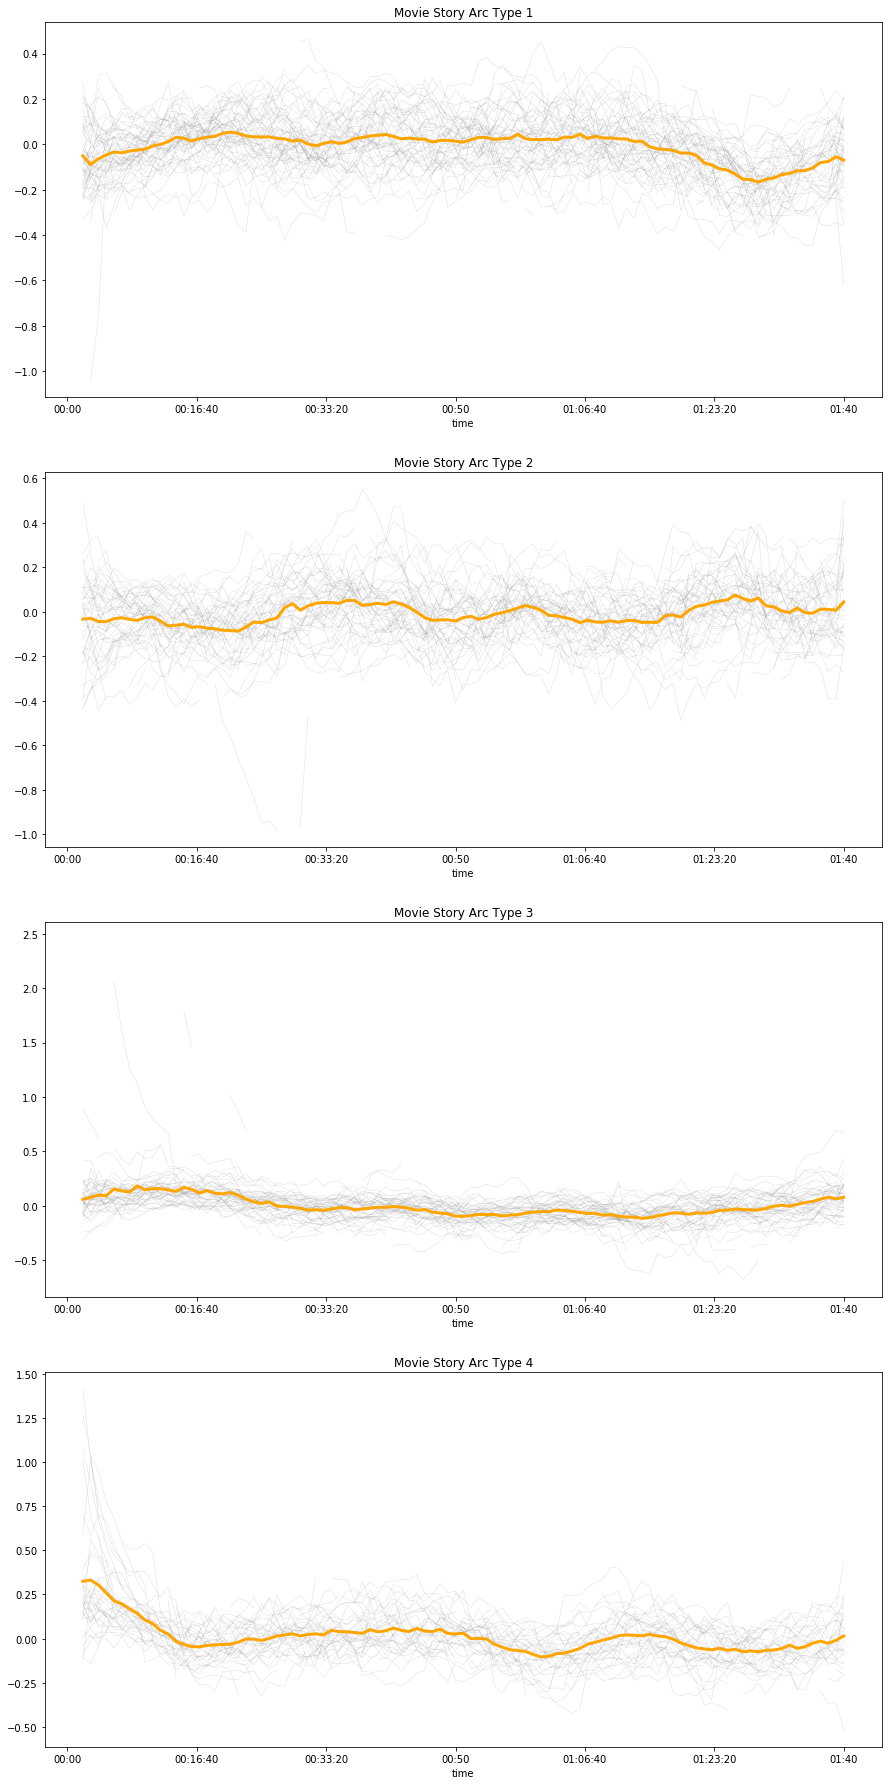

In [16]:
# Visualize each partition's sentiment arcs

fig,ax = plt.subplots(len(set(parts.part.unique())), figsize = (15,40))
for i,part in enumerate(range(len(set(partition.values())))):
    d = df_smooth.loc[df_smooth.part==part, :]
    if len(d)>10:
        d.normed_t = d.normed_t.dt.time
        d1 = d.groupby(['ttid','normed_t'])['normed_pol'].mean().unstack('ttid') 
        d2 = d.groupby(['normed_t'])['normed_pol'].mean()

        ax[i].plot(d1, c = 'gray', alpha = .25, linewidth = .5)
        ax[i].plot(d2, c = 'orange', alpha = 1, linewidth = 3)
        ax[i].set_title('Movie Story Arc Type {}'.format(part+1))
    else:
        fig.delaxes(ax[i])